In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import sklearn as sk

# GPU Setup

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[:-1], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  # Logical device was not created for first GPU
  assert len(logical_devices) == len(physical_devices) - 1
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Data preprocessing

In [3]:
# Build dataset
# python -m tensorflow_datasets.scripts.download_and_prepare --datasets=mri_dataset --module_import=mri_dataset --manual_dir=../../data/mri_dataset

In [4]:
import tensorflow_datasets as tfds
from datasets.mri_dataset import MriDataset
from tensorflow.data import Dataset


data_folder = 'data'
dataset = 'mri_dataset'
train_label = 'train_label.csv'
train_folder = 'train'
test_folder = 'test'


TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
IMG_SIZE = (512, 512)
SEED = 0


num_classes = 3
train_folds = tfds.load(
    name='mri_dataset', 
    split=[f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 10)], # 'train[:90%]' 
    download=False, 
    shuffle_files=False, 
    as_supervised=True
)
valid_folds = tfds.load(
    name='mri_dataset', 
    split=[f'train[{k}%:{k+10}%]' for k in range(0, 100, 10)], # 'train[:-10%]' 
    download=False, 
    shuffle_files=False, 
    as_supervised=True
)
test_ds, test_info = tfds.load(name='mri_dataset', split='test', download=False, shuffle_files=False, as_supervised=False, with_info=True)

train_folds = [ ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))).batch(TRAIN_BATCH_SIZE) for ds in train_folds ]
valid_folds = [ ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))).batch(VALID_BATCH_SIZE) for ds in valid_folds ]

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_folds = [ ds.prefetch(buffer_size=AUTOTUNE) for ds in train_folds ]
valid_folds = [ ds.prefetch(buffer_size=AUTOTUNE) for ds in valid_folds ]
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

train_ds = train_folds[0]
valid_ds = valid_folds[0]

In [5]:
train_valid_df = pd.read_csv(os.path.join(data_folder, dataset, train_label))
print(f'Number of train batches: {train_ds.cardinality()}')
print(f'Number of valid batches: {valid_ds.cardinality()}')
print(f'Number of test batches: {test_ds.cardinality()}')

Number of train batches: 33
Number of valid batches: 4
Number of test batches: 292


/home/zongsien/MedicalImageClassifier/env/lib/python3.7/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


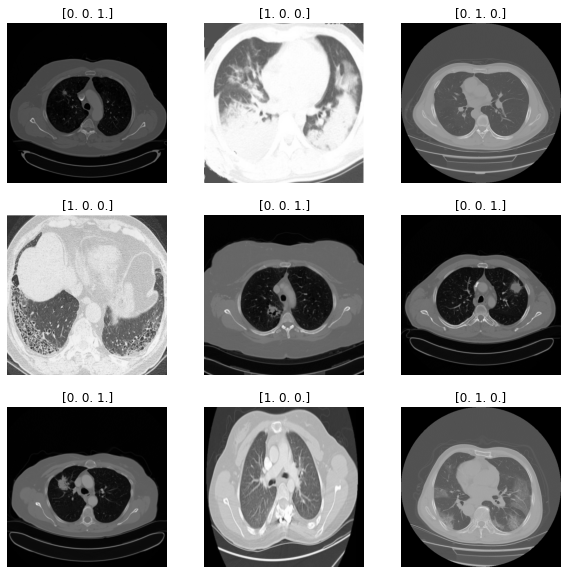

In [6]:
# Train Data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(labels[i].numpy())
      plt.axis("off")

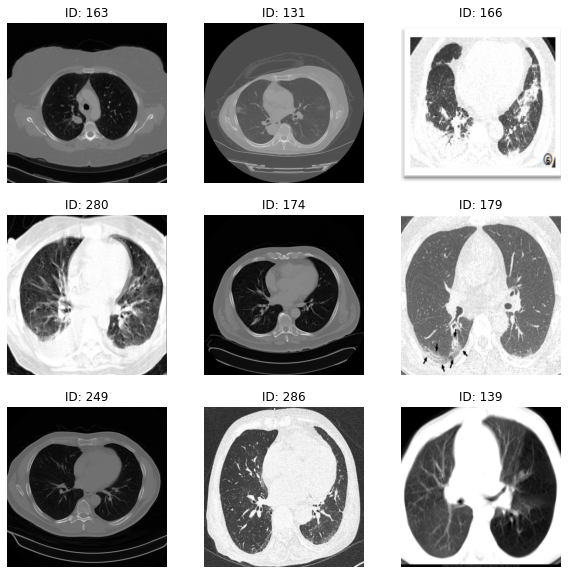

In [7]:
# Test Data
plt.figure(figsize=(10, 10))
for i, ds in enumerate(test_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(ds['image'].numpy().astype("uint8"))
    plt.title('ID: {}'.format(ds['id'].numpy()))
    plt.axis("off")

### Configure the dataset for performance

In [8]:
def create_augmentation_layer():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])
    return data_augmentation


def create_resize_and_rescale_layer(): 
    resize_and_rescale = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE[0], IMG_SIZE[1], interpolation='bilinear'),
        tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
    ])
    return resize_and_rescale


def create_base_model(img_shape):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    return base_model


def create_prediction_layer(num_classes):
    prediction_layer = tf.keras.Sequential([
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
    ])
    return prediction_layer


def create_model():
    IMG_SHAPE = IMG_SIZE + (3,)
    num_classes = 3

    base_model = create_base_model(IMG_SHAPE)
    data_augmentation = create_augmentation_layer()
    resize_and_rescale = create_resize_and_rescale_layer()
    prediction_layer = create_prediction_layer(num_classes)

    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = resize_and_rescale(x)
    x = base_model(x, training=False)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    return model


def create_fine_tune_model(model, fine_tune_at=100):
    model.layers[3].trainable = True
    print("Number of layers in the base model: ", len(model.layers[3].layers))

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[3].layers[:fine_tune_at]:
        layer.trainable = False
    return model


def compile_and_fit(model, train_ds, valid_ds, hyperparams, start_epoch=0):
    if start_epoch != 0:
        total_epochs =  hyperparams['initial_epochs'] + hyperparams['fine_tune_epochs']
        lr = hyperparams['learning_rate'] / 10
    else:
        total_epochs =  hyperparams['initial_epochs']
        lr = hyperparams['learning_rate']

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=hyperparams['label_smoothing']),
        metrics=['accuracy']
    )
    print(model.summary())
    history = model.fit(
        train_ds,
        epochs=total_epochs,
        initial_epoch=start_epoch,
        validation_data=valid_ds
    )
    return model, history


def plot(acc, val_acc, loss, val_loss, initial_epochs=0):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1.0])
    plt.title('Training and Validation Accuracy')
    if initial_epochs != 0:
        plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    if initial_epochs != 0:
        plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
    plt.show()

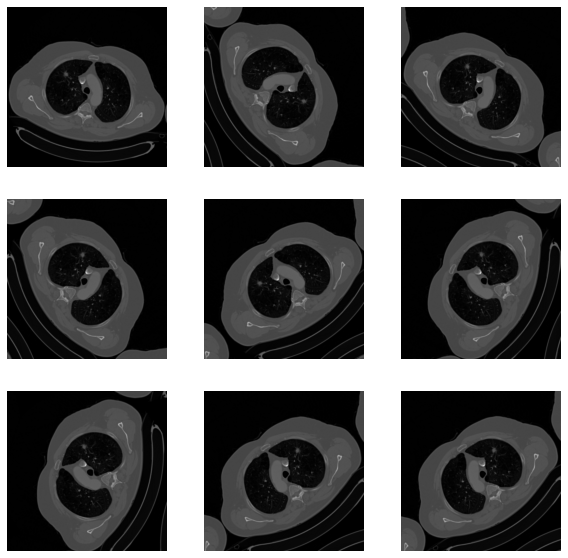

In [9]:
data_augmentation = create_augmentation_layer()

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Model

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

0 fold
0 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/2
33/33 [==============================] - 3s 98ms/step - loss: 1.18

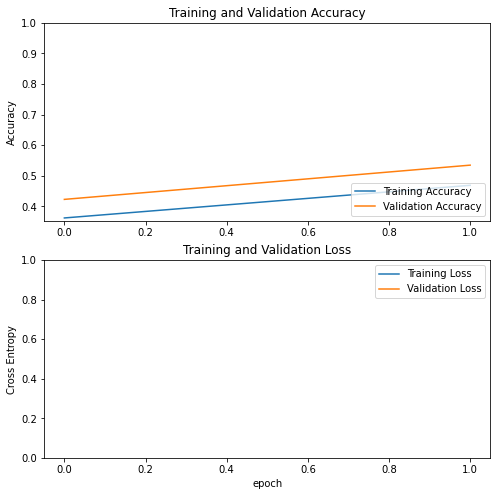


0 fold fine train:
Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________
None
Epoch 2/4
33/33 [=====================

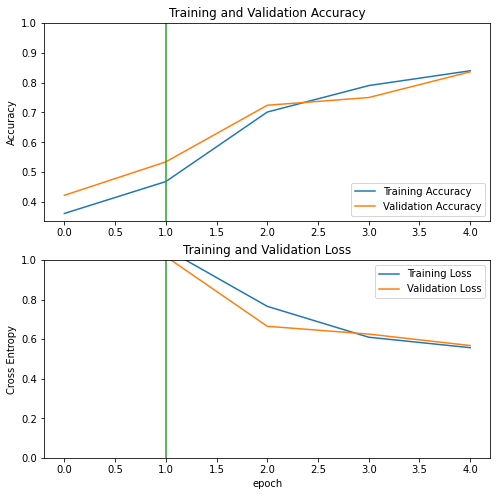


0 fold| Train Accuracy: 0.8396946787834167 | Validation Accuracy: 0.8362069129943848 | Train Loss: 0.5571268796920776 | Validation Loss: 0.5679430961608887

1 fold
1 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params:

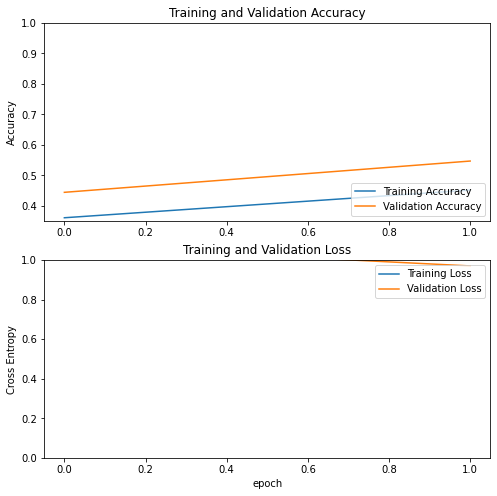


1 fold fine train:
Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________
None
Epoch 2/4
33/33 [=====================

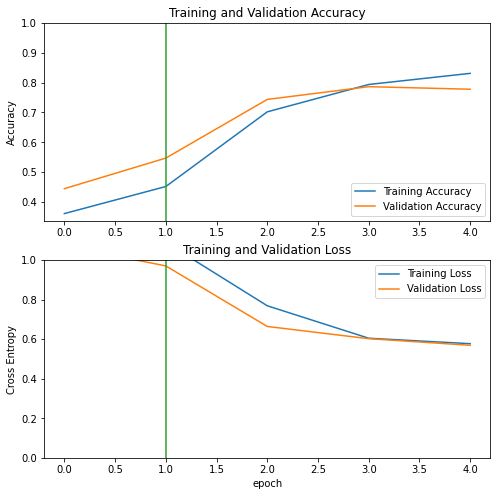


1 fold| Train Accuracy: 0.8309455513954163 | Validation Accuracy: 0.7777777910232544 | Train Loss: 0.5773119330406189 | Validation Loss: 0.5692262053489685

2 fold
2 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params:

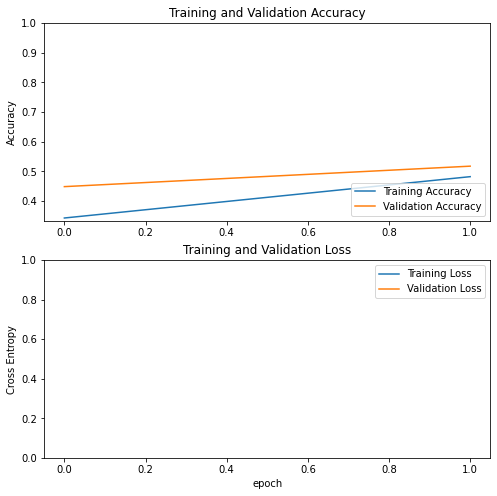


2 fold fine train:
Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________
None
Epoch 2/4
33/33 [=====================

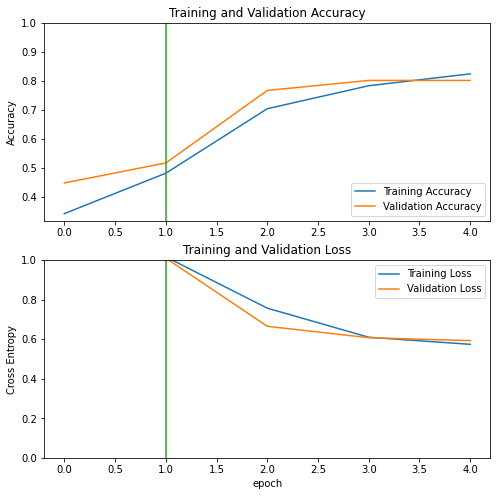


2 fold| Train Accuracy: 0.8244274854660034 | Validation Accuracy: 0.8017241358757019 | Train Loss: 0.5740859508514404 | Validation Loss: 0.5926896333694458

3 fold
3 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params:

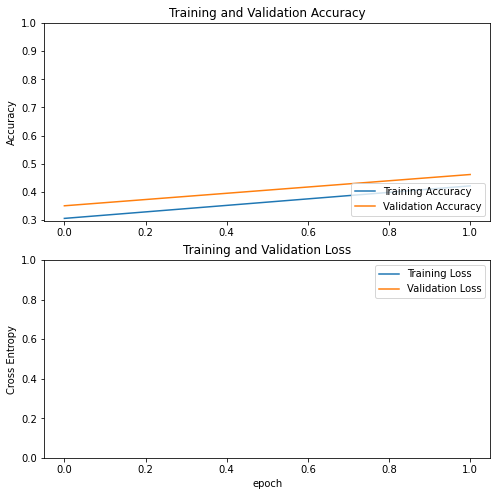


3 fold fine train:
Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________
None
Epoch 2/4
33/33 [=====================

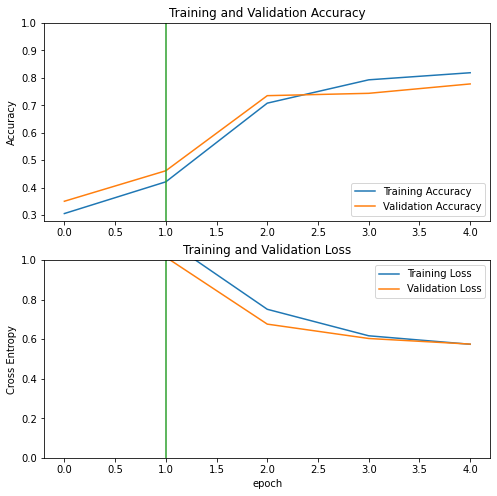


3 fold| Train Accuracy: 0.8185291290283203 | Validation Accuracy: 0.7777777910232544 | Train Loss: 0.5743306279182434 | Validation Loss: 0.5751680135726929

4 fold
4 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params:

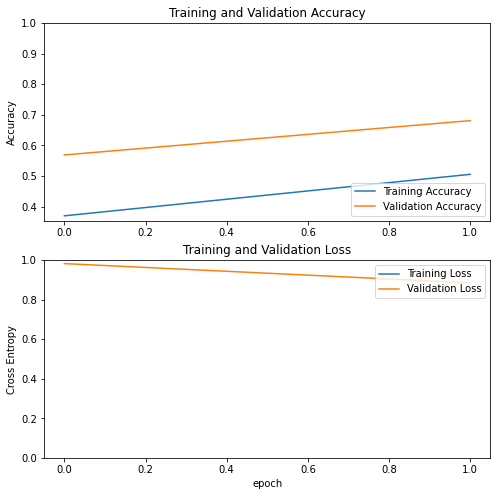


4 fold fine train:
Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________
None
Epoch 2/4
33/33 [=====================

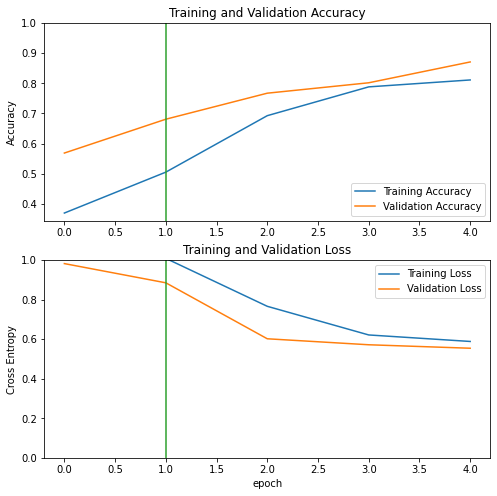


4 fold| Train Accuracy: 0.8110687136650085 | Validation Accuracy: 0.8706896305084229 | Train Loss: 0.588555634021759 | Validation Loss: 0.5542778372764587

5 fold
5 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 

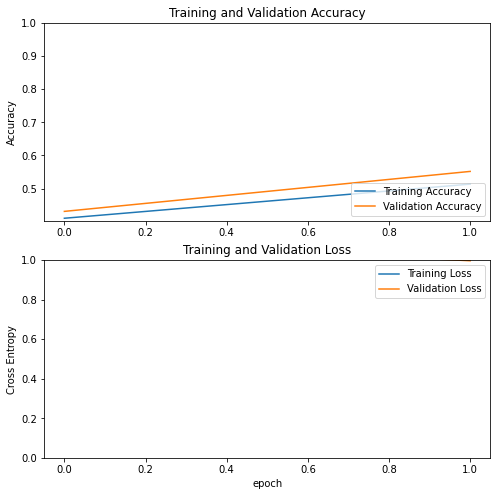


5 fold fine train:
Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________
None
Epoch 2/4
33/33 [=====================

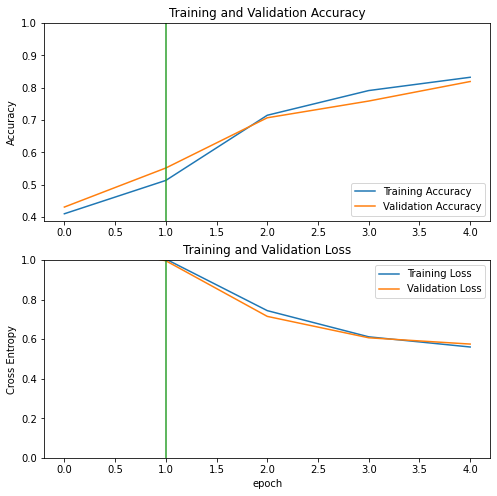


5 fold| Train Accuracy: 0.8320610523223877 | Validation Accuracy: 0.818965494632721 | Train Loss: 0.5605020523071289 | Validation Loss: 0.5753547549247742

6 fold
6 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 

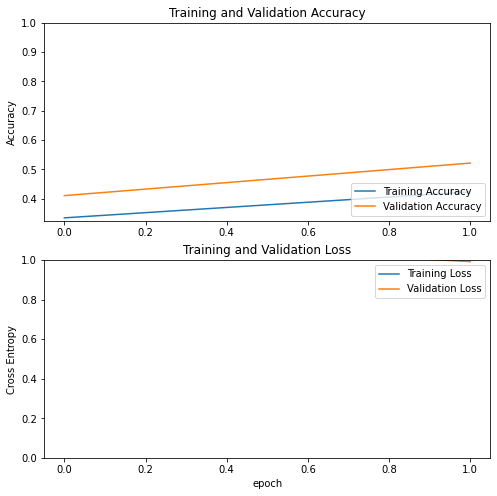


6 fold fine train:
Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________
None
Epoch 2/4
33/33 [=====================

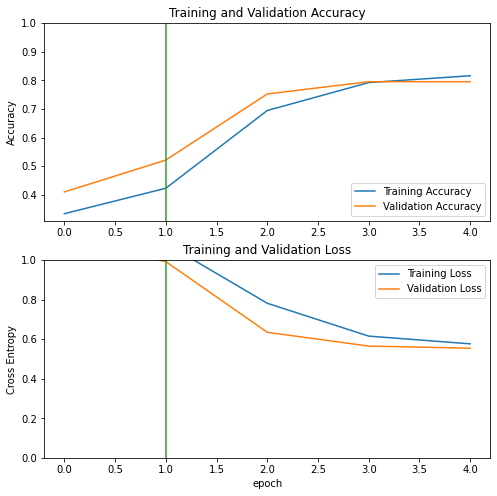


6 fold| Train Accuracy: 0.8156638145446777 | Validation Accuracy: 0.7948718070983887 | Train Loss: 0.5765064358711243 | Validation Loss: 0.5543550848960876

7 fold
7 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params:

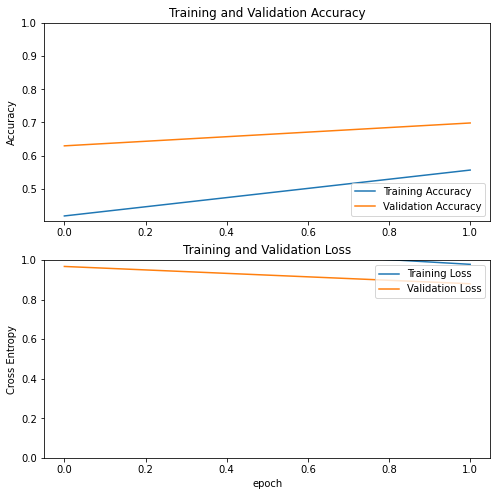


7 fold fine train:
Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________
None
Epoch 2/4
33/33 [=====================

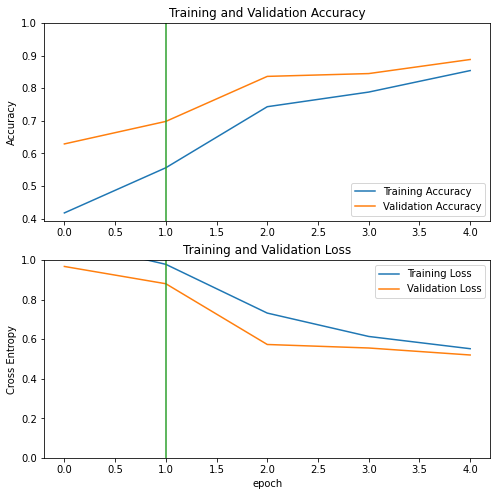


7 fold| Train Accuracy: 0.8540076613426208 | Validation Accuracy: 0.8879310488700867 | Train Loss: 0.5518718957901001 | Validation Loss: 0.5200380682945251

8 fold
8 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params:

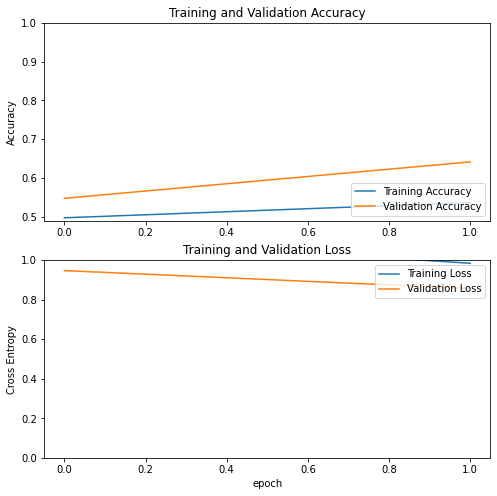


8 fold fine train:
Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________
None
Epoch 2/4
33/33 [=====================

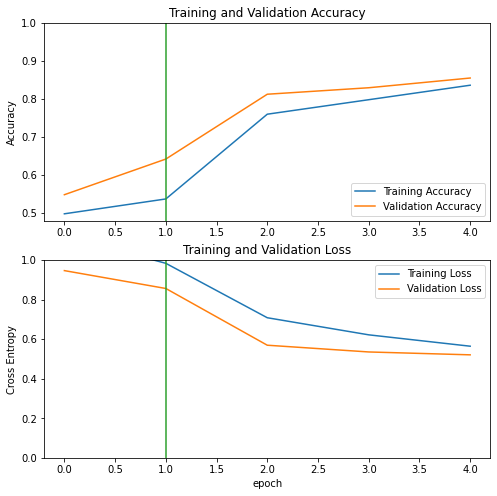


8 fold| Train Accuracy: 0.8357211351394653 | Validation Accuracy: 0.8547008633613586 | Train Loss: 0.564542293548584 | Validation Loss: 0.5208738446235657

9 fold
9 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 

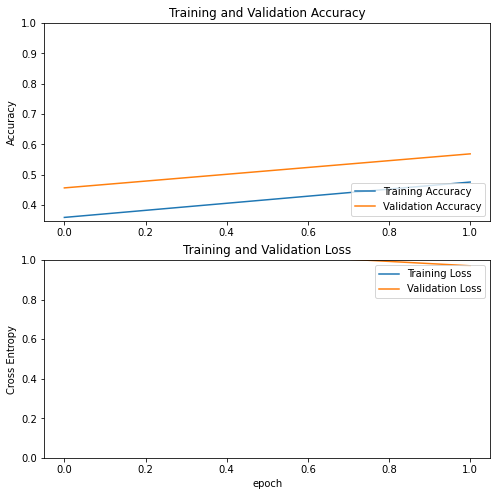


9 fold fine train:
Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________
None
Epoch 2/4
33/33 [=====================

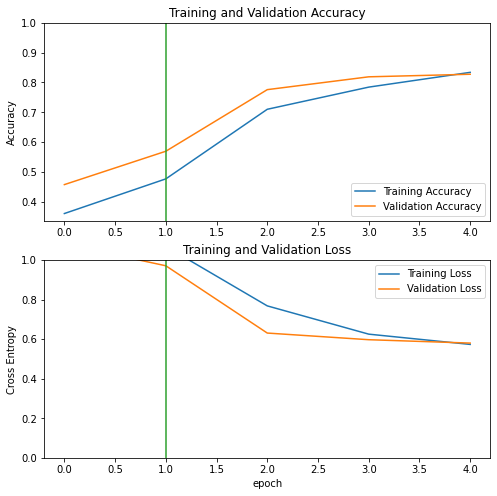


9 fold| Train Accuracy: 0.8339694738388062 | Validation Accuracy: 0.8275862336158752 | Train Loss: 0.573602557182312 | Validation Loss: 0.5802916288375854

Train Accuracy: 0.8296088695526123 | Validation Accuracy: 0.8248231709003448 | Train Loss: 0.573602557182312 | Validation Loss: 0.5802916288375854


In [10]:
%%time

tf.random.set_seed(SEED)
hyperparams = {
    'initial_epochs': 150, # 150
    'fine_tune_epochs': 50, # 50
    'learning_rate': 5e-5,
    'label_smoothing': 0.05,
}

train_accs, valid_accs, train_losses, valid_losses = [], [], [], []
for i, (train_ds, valid_ds) in enumerate(zip(train_folds, valid_folds)):
    k = i + 1
    print(f'# --------------------{k} fold -------------------- #')
    tf.keras.backend.clear_session()
    model = create_model()
    
    print(f'{k} fold pre train:') 
    model, history = compile_and_fit(model, train_ds, valid_ds, hyperparams)
    print()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plot(acc, val_acc, loss, val_loss)
    print()

    print(f'{k} fold fine train:')     
    model = create_fine_tune_model(model, fine_tune_at=100)
    model, history_fine = compile_and_fit(model, train_ds, valid_ds, hyperparams, start_epoch=history.epoch[-1])
    print()

    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']
    plot(acc, val_acc, loss, val_loss, initial_epochs=hyperparams['initial_epochs'])
    print()

    # record accuracy
    train_acc = history.history['accuracy'][-1]
    valid_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    valid_loss = history.history['val_loss'][-1]

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'{k} fold | Train Accuracy: {train_acc} | Validation Accuracy: {valid_acc} | Train Loss: {train_loss} | Validation Loss: {valid_loss}\n')

# average accuracy
avg_train_acc = np.mean(train_accs)
avg_valid_acc = np.mean(valid_accs)
avg_train_loss = np.mean(train_loss)
avg_valid_loss = np.mean(valid_loss)

print(f'Avg Train Accuracy: {avg_train_acc} | Avg Validation Accuracy: {avg_valid_acc} | Avg Train Loss: {avg_train_loss} | Avg Validation Loss: {avg_valid_loss}')

# Train and Validate

# Prediction

In [24]:
tf.random.set_seed(SEED)

# TODO: combine ds and retrain
# combined_ds = train_ds.concatenate(valid_ds)

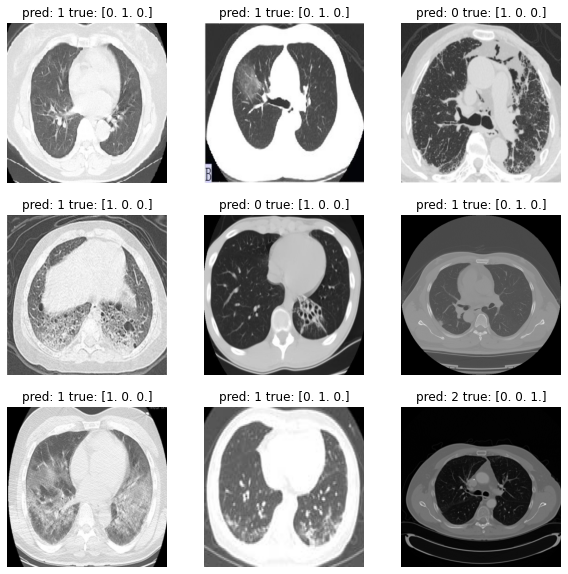

In [21]:
image_batch, label_batch = valid_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_indices = tf.argmax(predictions, 1)
predicted_labels = predicted_indices.numpy()


plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f'pred: {predicted_labels[i]} true: {label_batch[i]}')
  plt.axis("off")

# Evaluate

In [26]:
ds = test_ds.map(lambda ds: (ds['image'], ds['label'])).batch(TEST_BATCH_SIZE)
predictions = model.predict(ds)
predicted_indices = tf.argmax(predictions, 1)
predicted_labels = predicted_indices.numpy()
predicted_labels

array([2, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
       1, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       2, 1, 2, 0, 2, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 0, 2, 1,
       1, 0, 1, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1,
       1, 0, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 2,
       1, 1, 1, 0, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1, 0, 2, 1, 0, 0,
       2, 1, 1, 0, 1, 1, 2, 2, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 2,
       0, 1, 2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       2, 1, 0, 0, 1, 0, 1, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 1, 2, 1, 0, 2,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 2, 2, 1, 2, 0, 1,
       0, 2, 0, 1, 1, 1])

In [27]:
def save_results(save_path, image_ids, predicted_labels):
    results = image_ids.drop('image', axis=1)
    results.columns = ['ID', 'Label']
    results['Label'] = predicted_labels 
    results = results.sort_values('ID').reset_index(drop=True)
    results.to_csv(RESULT_SAVE_PATH, index=False)


RESULT_SAVE_PATH = 'submission.csv'

img_ids = tfds.as_dataframe(test_ds, test_info)
save_results(RESULT_SAVE_PATH, img_ids, predicted_labels)